```
From: https://github.com/ksatola
Version: 0.0.1

TODOs
1. https://github.com/vsatyakumar/automatic-local-outlier-factor-tuning
2. https://medium.com/learningdatascience/anomaly-detection-techniques-in-python-50f650c75aaf
3. https://stats.stackexchange.com/questions/138675/choosing-a-k-value-for-local-outlier-factor-lof-detection-analysis
4. Isolation Forest for Outliers detection (see below)
5. https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html

```

In [4]:
# Connect with underlying Python code
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

In [5]:
from datasets import (
    get_dataset,
)
from prepare import (
    identify_outliers,
)

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Outliers
When modeling, it is important to clean the data sample to ensure that the observations best represent the problem. Sometimes a dataset can contain extreme values that are outside the range of what is expected and unlike the other data. These are called `outliers` and often machine learning modeling and model skill in general can be improved by understanding and even removing these outlier values.

An `outlier` is an observation that is unlike the other observations. It is rare, or distinct, or does not fit in some way. We will generally define outliers as samples that are exceptionally far from the mainstream of the data. 

Outliers can have many causes, such as:
- Measurement or input error,
- Data corruption,
- True outlier observation.

**There is no precise way to define and identify outliers in general because of the specifics of each dataset**. Instead, you, or a domain expert, must interpret the raw observations and decide whether a value is an outlier or not. Nevertheless, `we can use statistical methods to identify observations that appear to be rare or unlikely given the available data`.

Identifying outliers and bad data in your dataset is probably one of the most difficult parts of data cleanup, and it takes time to get right. Even if you have a deep understanding of statistics and how outliers might affect your data, it’s always a topic to explore cautiously. 

A good tip is to consider plotting the identified outlier values, perhaps in the context of non-outlier values to see if there are any systematic relationship or pattern to the outliers. If there is, perhaps they are not outliers and can be explained, or perhaps the outliers themselves can be identified more systematically.

mean=50.049 stdv=4.994


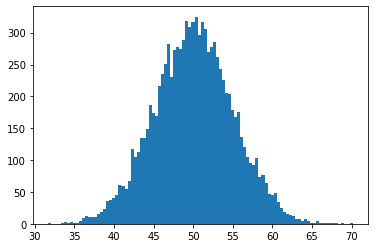

In [7]:
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std

# Seed the random number generator
seed(1)
# Generate univariate observations
data = 5 * randn(10000) + 50
# Summarize
print(f'mean={mean(data):.3f} stdv={std(data):.3f}')
# Plot the data distribution
plt.hist(x=data, bins=100)
plt.show()

## Standard Deviation Method (For Normally Distributed Data)
**If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers**. The `Gaussian distribution` has the property that the standard deviation from the mean can be used to reliably summarize the percentage of values in the sample. So, if the mean is 50 and the standard deviation is 5, as in the test dataset above, then all data in the sample between 45 and 55 will account for about 68% of the data sample. We can cover more of the data sample if we expand the range as follows:
- 1 Standard Deviation from the Mean: 68%
- 2 Standard Deviations from the Mean: 95%
- 3 Standard Deviations from the Mean: 99.7%

A value that falls outside of 3 standard deviations is part of the distribution, but it is an `unlikely or rare event` at approximately 1 in 370 samples.

**Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution**. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.

Given `mu` and `sigma`, a simple way to identify outliers is to compute a `Z-score` for every xi, which is defined as the number of standard deviations away xi is from the mean. Data values that have a `Z-score` sigma greater than a threshold, for example, of three, are declared to be `outliers`.

Sometimes, the data is standardized first (e.g. to a `Z-score` with zero mean and unit variance) so that the outlier detection can be performed using standard `Z-score` cut-off values. This is a convenience and is not required in general, and we will perform the calculations in the original scale of the data here to make things clear.

We can calculate the mean and standard deviation of a given sample, then calculate the cut-off for identifying outliers as more than 3 standard deviations from the mean.

In [8]:
# Calculate summary statistics
data_mean, data_std = mean(data), std(data)

# Identify outliers
cut_off = data_std * 3
lower = data_mean - cut_off
upper = data_mean + cut_off

In [9]:
data_mean

50.04886328349552

In [10]:
data_std

4.993929218440242

In [11]:
cut_off

14.981787655320726

In [12]:
lower

35.06707562817479

In [13]:
upper

65.03065093881625

In [14]:
# Identify outliers
outliers = [x for x in data if x < lower or x > upper]
outliers.sort() # this returns None, and sorts the list in place
outliers

[31.717799503726024,
 33.525707966507426,
 33.6969245211173,
 33.73482882511691,
 33.90433947188079,
 34.0469182658796,
 34.23321274904475,
 34.679293219474495,
 34.72183379792847,
 34.73117809786848,
 34.91984007395351,
 65.06377284118616,
 65.15428556186015,
 65.55945915508362,
 65.59239795391275,
 65.66014864070253,
 65.67523670043954,
 65.74492012609815,
 66.19171598376188,
 66.49270261640393,
 66.60539378085183,
 66.99057828251213,
 67.02151137874486,
 67.1633171589778,
 67.80436660352774,
 68.06638503541573,
 68.70124451852294,
 69.79301352018982,
 70.1342452227369]

In [15]:
# Remove outliers
outliers_removed = [x for x in data if x > lower and x < upper]

In [16]:
print(f'Identified outliers: {len(outliers)}')
print(f'Non-outlier observations: {len(outliers_removed)}')

Identified outliers: 29
Non-outlier observations: 9971


### STD: Example

In [17]:
# Load data
df = pd.read_csv('../data/boston_housing.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


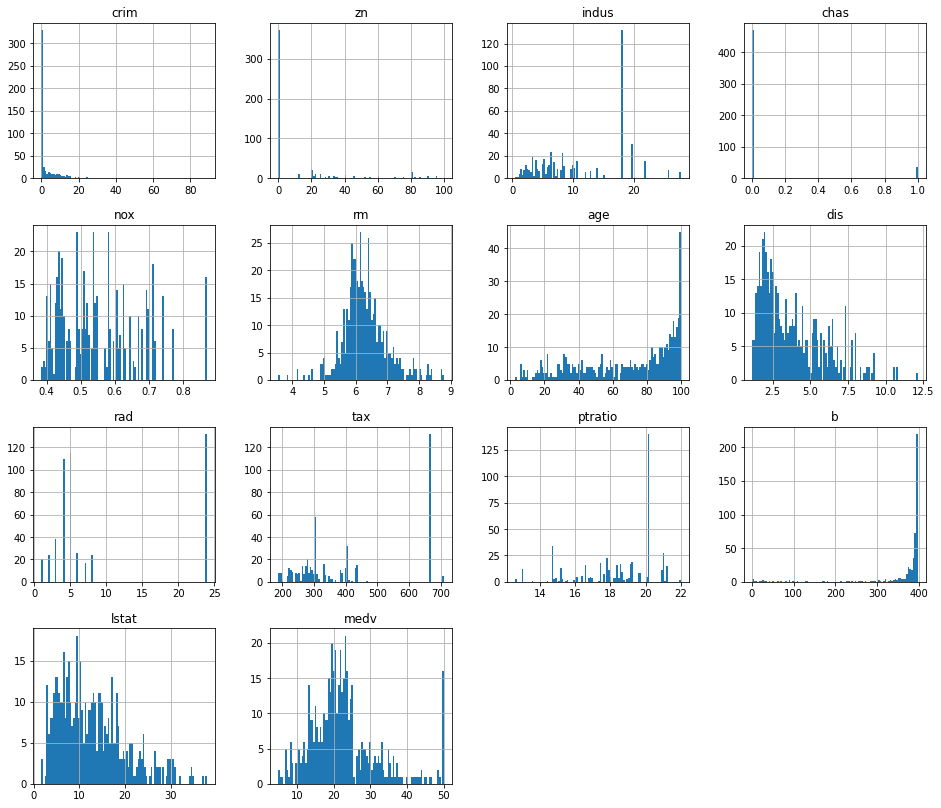

In [18]:
df.hist(figsize=(16, 14), bins=100);

In [19]:
cols_for_std = ['rm']
outlier_indexes_std = []
for col in cols_for_std:
    outlier_indexes_std_col = identify_outliers(data=df[col], cut_off_limit=3, method='std')
    outlier_indexes_std += outlier_indexes_std_col
len(outlier_indexes_std)

Mean: 6.285, cut_off: 2.106, lower_limit: 4.179, upper_limit: 8.390


8

## Interquartile Range Method (For Non-Gaussian Distributions of Data)
Not all data is normal or normal enough to treat it as being drawn from a Gaussian distribution. A good statistic for summarizing a non-Gaussian distribution sample of data is the `Interquartile Range`, or `IQR` for short. The `IQR` is calculated as the **difference between the 75th and the 25th percentiles of the data** and defines the box in a `box and whisker plot`.

Remember that `percentiles` can be calculated by sorting the observations and selecting values at specific indices. The `50th percentile` is the middle value, or the average of the two middle values for an even number of examples. If we had 10,000 samples, then the 50th percentile would be the average of the 5000th and 5001st values. We refer to the percentiles as quartiles (`quart` meaning 4) because the data is divided into four groups via the 25th, 50th and 75th values. **The `IQR` defines the middle 50% of the data, or the body of the data.**

**The `IQR` can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers or far outs when described in the context of `box and whisker plots`**.

On a `box and whisker plot`, these limits are drawn as fences on the whiskers (or the lines) that are drawn from the box. Values that fall outside of these values are drawn as dots.

We can calculate the percentiles of a dataset using the `percentile()` NumPy function that takes the dataset and specification of the desired percentile. The `IQR` can then be calculated as the difference between the 75th and 25th percentiles.

In [20]:
from numpy.random import seed
from numpy.random import randn
from numpy import percentile

In [21]:
# Calculate interquartile range
q25, q75 = percentile(data, 25), percentile(data, 75)
print(q25, q75)

46.685375790489445 53.3590441773518


In [22]:
# or
q25, q75 = percentile(data, [25, 75])
print(q25, q75)

46.685375790489445 53.3590441773518


In [23]:
iqr = q75 - q25
iqr

6.673668386862353

In [24]:
print(f'Percentiles: 25th={q25:.3f}, 75th={q75:.3f}, IQR={iqr:.3f}')

Percentiles: 25th=46.685, 75th=53.359, IQR=6.674


In [25]:
# Calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
print(cut_off, lower, upper)

10.01050258029353 36.67487321019591 63.369546757645324


In [26]:
# Identify outliers
outliers = [x for x in data if x < lower or x > upper]

In [27]:
# Remove outliers
outliers_removed = [x for x in data if x > lower and x < upper]

In [28]:
print(f'Identified outliers: {len(outliers)}')
print(f'Non-outlier observations: {len(outliers_removed)}')

Identified outliers: 81
Non-outlier observations: 9919


### IQR: Example

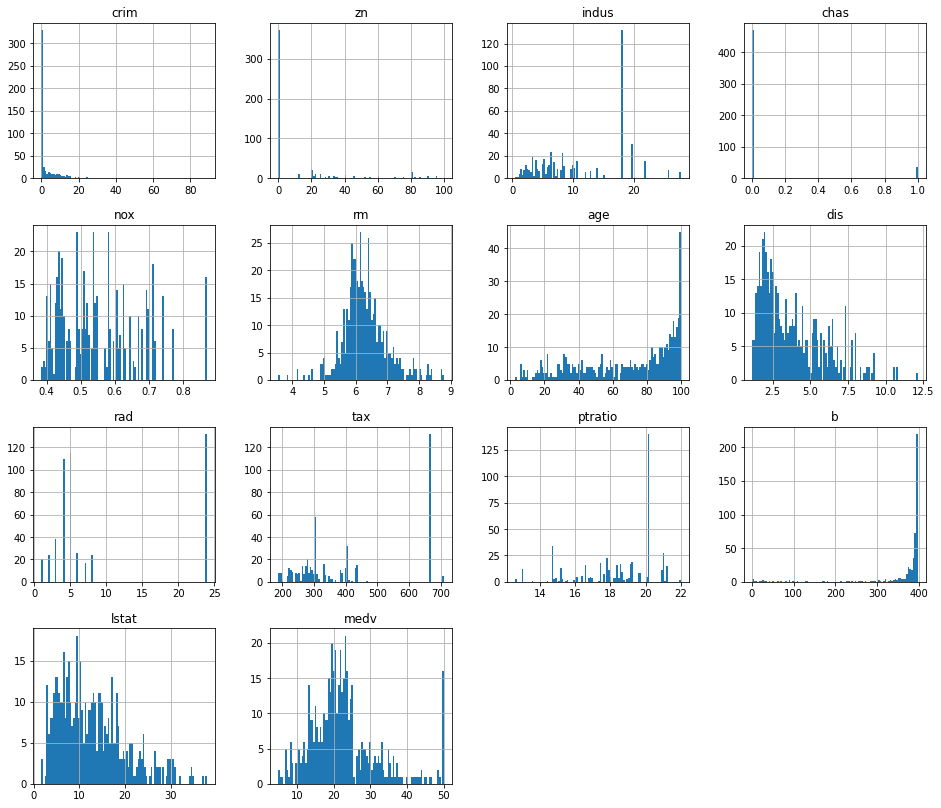

In [29]:
df.hist(figsize=(16, 14), bins=100);

In [21]:
cols_for_iqr = ['age', 'dis']
outlier_indexes_iqr = []
for col in cols_for_iqr:
    outlier_indexes_iqr_col = identify_outliers(data=df[col], cut_off_limit=3, method='iqr')
    outlier_indexes_iqr += outlier_indexes_iqr_col
len(outlier_indexes_iqr)

Percentiles: 25th=45.025, 75th=94.075, IQR=49.050, cut_off: 147.150, lower_limit: -102.125, upper_limit: 241.225
Percentiles: 25th=2.100, 75th=5.188, IQR=3.088, cut_off: 9.265, lower_limit: -7.165, upper_limit: 14.453


0

## Visual Way of Identifying Outliers
It is always a good idea to check data for outliers visually. For detailed description and the meaning of the plot see: https://seaborn.pydata.org/generated/seaborn.boxplot.html.

<AxesSubplot:>

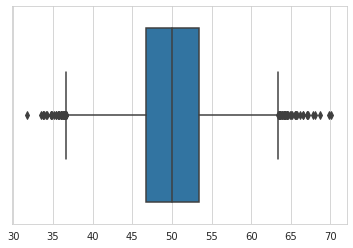

In [30]:
sns.set_style("whitegrid") 
sns.boxplot(x = data)

<img src="images/box_plot_outliers.png" alt="" style="width: 600px;"/>

## Unsupervised Outlier Detection using Local Outlier Factor (LOF) for Automatic Outlier / Anomaly Detection
In machine learning, an approach to tackling the problem of outlier detection is `one-class classification`. One-Class Classification, or `OCC` for short, involves fitting a model on the "normal" data and predicting whether new data is normal or an `outlier/anomaly`. **A one-class classifier is fit on a training dataset that only has examples from the normal class**. Once prepared, the model is used to classify new examples as either normal or not-normal, i.e. `outliers` or `anomalies`.

A simple approach to identifying outliers is to locate those examples that are far from the other examples in the feature space. This can work well for feature spaces with low dimensionality (few features), although it can become less reliable as the number of features is increased, referred to as the `curse of dimensionality`.

The `local outlier factor`, or `LOF` for short, is a technique that attempts to harness the idea of nearest neighbors for `outlier detection`. Each example is assigned a scoring of how isolated or how likely it is to be outliers based on the size of its local neighborhood. Those examples with the largest score are more likely to be outliers. The scikit-learn library provides an implementation of this approach in the [LocalOutlierFactor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) class. 

Here is:
- the [original paper](https://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf),
- [Automatic Hyperparameter Tuning Method for Local Outlier Factor](https://arxiv.org/pdf/1902.00567.pdf)

The anomaly score of each sample is called `Local Outlier Factor`. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by `k-nearest neighbors`, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered `outliers`.


https://stats.stackexchange.com/questions/138675/choosing-a-k-value-for-local-outlier-factor-lof-detection-analysis

We can demonstrate the LocalOutlierFactor method on a predictive modelling dataset. The Boston housing regression problem that has 13 inputs and one numerical target and requires learning the relationship between suburb characteristics and house prices.

First, we can load the dataset as a NumPy array, separate it into input and output variables and then split it into train and test datasets.

In [31]:
# target = 'medv'
df = get_dataset('boston_housing')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [32]:
# Retrieve the array
data = df.values
data[:5]

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01,
        6.5750e+00, 6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02,
        1.5300e+01, 3.9690e+02, 4.9800e+00, 2.4000e+01],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9690e+02, 9.1400e+00, 2.1600e+01],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        7.1850e+00, 6.1100e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9283e+02, 4.0300e+00, 3.4700e+01],
       [3.2370e-02, 0.0000e+00, 2.1800e+00, 0.0000e+00, 4.5800e-01,
        6.9980e+00, 4.5800e+01, 6.0622e+00, 3.0000e+00, 2.2200e+02,
        1.8700e+01, 3.9463e+02, 2.9400e+00, 3.3400e+01],
       [6.9050e-02, 0.0000e+00, 2.1800e+00, 0.0000e+00, 4.5800e-01,
        7.1470e+00, 5.4200e+01, 6.0622e+00, 3.0000e+00, 2.2200e+02,
        1.8700e+01, 3.9690e+02, 5.3300e+00, 3.6200e+01]])

In [33]:
# Split into input and output elements
X, y = data[:, :-1], data[:, -1]

# Summarize the shape of the dataset
print(X.shape, y.shape)

from sklearn.model_selection import train_test_split

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Summarize the shape of the train and test sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(506, 13) (506,)
(339, 13) (167, 13) (339,) (167,)


It is a regression predictive modeling problem, meaning that we will be predicting a numeric value. All input variables are also numeric. In this case, we will fit a linear regression algorithm and evaluate model performance by training the model on the train dataset and making a prediction on the test data and evaluate the predictions using the mean absolute error (MAE). Normally, before using the linear regression for modelling, in order to trust the results, we should check its assumptions first (this step is ommited for brevity).

In [34]:
# Evaluate model on training dataset without outliers removed
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
yhat = model.predict(X_test)

# Evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print(f'MAE: {mae:.3f}')

MAE: 3.417


The expectation is that the outliers are causing the linear regression model to learn a bias or skewed understanding of the problem, and that removing these outliers from the training set will allow a more effective model to be learned.

We can achieve this by defining the `LocalOutlierFactor` model and using it to make a prediction on the training dataset, marking each row in the training dataset as normal (`1`) or an outlier (`-1`). We will use the default hyper-parameters for the outlier detection model, although it is a good idea to tune the configuration to the specifics of your dataset.

In [35]:
# Evaluate model on training dataset with outliers removed
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error

# Identify outliers in the training dataset
lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)

# Select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]

# Summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
yhat = model.predict(X_test)

# Evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print(f'MAE: {mae:.3f}')

(305, 13) (305,)
MAE: 3.356


Firstly, we can see that the number of examples in the training dataset has been reduced from 339 to 305, meaning 34 rows containing outliers were identified and deleted. We can also see a reduction in MAE from about 3.417 by a model fit on the entire training dataset, to about 3.356 on a model fit on the dataset with outliers removed.

## Isolation Forest
Some of the points that we are dealing with may be multi-dimensional outliers and we wouldn't like to work with them as they are corrupting most of the algorithms that are used for classification / regression. We will get rid of them using another random-forest-based algorithm called Isolation Forest.

In [36]:
from sklearn.ensemble import IsolationForest

In [45]:
target_name = 'medv'
df = get_dataset('boston_housing')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [47]:
y = df[[target_name]]
X = df.drop(columns=[target_name])

In [48]:
# we assume that ~2% of all observations are outliers - should be discussed with a subject expert
isolation_forest = IsolationForest(n_estimators=200, contamination=0.02, n_jobs=-1, random_state=250)

In [49]:
is_outlier = -1*isolation_forest.fit_predict(X)

In [50]:
np.unique(is_outlier, return_counts=True)

(array([-1,  1]), array([495,  11]))

In [54]:
# remove outliers
df_no_outliers = X.loc[~(is_outlier == 1)]
df_no_outliers.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33
